# CASSANDRA
The *Cassandra* dilemma occurs when valid warnings or concerns are dismissed or not believed. The term originates in Greek mythology. Cassandra was a daughter of Priam, the King of Troy. Struck by her beauty, Apollo provided her with the gift of prophecy, but when Cassandra refused Apollo's romantic advances, he placed a curse ensuring that nobody would believe her warnings. Cassandra was left with the knowledge of future events, but could neither alter these events nor convince others of the validity of her predictions.

---

## Problem Statement
Timing is absolutely key in financial markets. The ability to predict market peaks (both near-term and long-term) can help protect investors from significant drawdowns and elevated volatility. Of course, most of us do not have the luck of being endowed with such prophetic abilities. However, we may be able to leverage on the advances made in machine learning to create a more advanced barometer of risk (especially for US equity markets) to help investors navigate through the noise.

We define a *pullback* as whether the S&P 500 index will be lower in a month's time (i.e. rolling 4 weeks). The model we are looking to build should be able to do the following:
* Predict the likelihood that the S&P 500 index will fall over the coming month
* Explain which variables matter and how they interact

## Organisation of codebooks
1. **Data collection, EDA, Feature Engineering** <-- You're here
2. Pre-processing, model tuning and conclusions

In [23]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno # Visualising our missing values
import pickle # For exporting our dataset

from pandas_profiling import ProfileReport # Automating the EDA process
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import timedelta

# Custom function(s)
import SIREN_func

In [24]:
# Ensuring our notebook remains tidy
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Customising aesthetics
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
sns.set_palette('tab20c')

## Data collection
The bulk of our data has been sourced from Bloomberg via its API on excel. We will write a loop to pull every sheet and store in a dictionary for future use / manipulation. As with any model / algorithm, selecting which variables to include is one of the most important aspects of the workflow. I would like to think that my experience in financial markets should count for something here.

### Constructing our model
Fundamentals are definitely a key driver of equity market returns, especially over longer-term horizons, but near-term changes in flows, technicals, as well as sentiment also have an important role to play in near-term price action. With investors fluctuating between *Greed* and *Fear*, this often causes equity markets to overshoot. The data we've pulled can be broadly classified into the following categories:

* Macro barometers
    * Citi economic surprise indices
    * USD indices
    * Baker, Bloom & Davis US economic policy uncertainty index
    * Chicago Fed financial conditions index
    * Inflation expectations; US 5-year-5-year US inflation breakevens
* Fundamental indicators
    * Earnings revision ratios
    * 12-month forward P/E ratios
    * 12-month forward P/B ratios
* Sentiment indicators
    * Index performance (target variable)
    * VIX index
    * MOVE index
    * SKEW index
    * Put/call ratios (aggregated)
    * AAII sentiment (bull, bears)
    * CFTC net non-commercial longs for S&P 500 futures
* Commodities
    * Brent / WTI front-end contracts
    * Gold spot
    * Bloomberg Commodities Total Return Indices - Industrial metals
    * Bloomberg Commodities Total Return Indices - Energy
    * Bloomberg Commodities Total Return Indices - Precious metals
* Credit spreads
    * Bloomberg Barclays Global High-yield corporate bond option-adjusted spreads (OAS)
    * Bloomberg Barclays US High-yield (2% Issuer Cap) corporate bond option-adjusted spreads (OAS)
    * Bloomberg Barclays US Agg option-adjusted spreads (OAS)
    * JPMorgan EMBI Global Diversified Blended spread
    * JPMorgan Asia Credit Composite Blended spread
* Technical indicators
    * S&P 500 14-week RSIs
    * Percentage % of S&P 500 stocks with 14-week RSIs above 70
    * Percentage (%) of S&P 500 stocks at 52-week high)
* Rates
    * 2-year, 10-year 30-year US treasury bond yields
    * US 10-year Treasury inflation-protected securities (TIPS)
    * Fed funds rate (Proxy for Fed rate hiking regimes)
    * Eurodollar futures

### Importing dataset(s)
* `spx_fundamentals.xlsx`
* `spx_eri.xlsx`

In [26]:
# Read .xlsx highlighting S&P 500's earnings revisions
eri = pd.read_excel("../data/spx_eri.xlsx", sheet_name="Combined", parse_dates=['date'])

In [27]:
# Read each tab from our .xlsx file separately
xlsx = pd.ExcelFile('../data/spx_fundamentals_values.xlsx')

# Reading all sheets to a mapsheet_to_df_map = {}
empty_list = {}
for i in xlsx.sheet_names:
    empty_list[i] = pd.read_excel('../data/spx_fundamentals_values.xlsx', sheet_name=i, skiprows=11, parse_dates=['date'])

In [28]:
# Preview dictionary of dataframes
empty_list.keys()

dict_keys(['econ_sur', 'usd', 'epu', 'finc', 'pe', 'pb', 'eq_indices', 'como', 'credit', 'pct52w', 'vol', 'aaii', 'us_cftc', 'technicals', 'us_yields', 'eu_yields', 'eurdollar', 'fra_ois', 'fdtr', 'inflation'])

### Data dictionary
*Trimmed; Without transformations*
|ID|DESCRIPTION|TYPE|DATASET
|---|---|---|---|
|cesiusd|Citi Economic Surprise Index - US|numeric|econ_sur|
|usd_twi|Trade-weighted USD Index|numeric|usd|
|epu|Baker, Bloom and Davis US Economic Policy Uncertainty Index|numeric|epu|
|chicago_fed_finc|Chicago Fed's National Financial Conditions Index|numeric|finc|
|spx_pe|S&P 500 12-month forward Price-Earnings Ratio|numeric|pe|
|spx_pb|S&P 500 12-month forward Price-Book Ratio|numeric|pb|
|spx|S&P 500 Index|numeric|eq_indices|
|bcom_in|Bloomberg Commodities Total Return Indices - Industrial metals|numeric|como|
|brent|Brent front-end contract|numeric|como|
|gold|Gold spot (XAU/USD)|numeric|como|
|us_hy|US High-yield Corporate debt (2% Issuer cap)|numeric|credit|
|spx_52w|% of S&P 500 with new 52-week highs|numeric|pct52w|
|vix|CBOE VIX Index|numeric|vol|
|move|MOVE Index|numeric|vol|
|skew|SKEW Index|numeric|vol|
|aaii_bull|AAII - Bullish sentiment|numeric|aaii|
|cftc_nc_long|CFTC Net non-commercial positionos - S&P 500 futures only|numeric|us_cftc|
|cboe_us|CBOE Put-call ratios (Aggregate) for S&P 500|numeric|technicals|
|spx_rsi14d|S&P 500 14-week RSI|numeric|technicals|
|spx_pct_rsi14d_above70|% of S&P 500 index members with 14-week RSI > 70|numeric|technicals|
|us_2y|2-year US Treasury yields|numeric|us_yields|
|us_10y|10-year US Treasury yields (Risk-free rate)|numeric|us_yields|
|us_be5y5y|US 5-year-5-year breakevens|numeric|inflation|
|us_10y_real|US 10-year US Treasury Inflation-Protection Securities (TIPs) |numeric|inflation|

## Visualising our features

**Citi Economic Surprise Indices**

These indices essentially measure whether data releases from an economy or group of companies have beaten or missed expectations (Actual - Consensus expectations, normalised by 10-year standard deviation). The neutral level is zero. Because of the rolling 3-month calculation window and typically low auto-correlation of surprises, the index tends to revert to zero (Extended positive or negative readings are an indication of bias in expectations). 

The index level tells us the number of standard deviations of surprises (in basis points) what the aggregate decay-adjusted surprise in the past 3 months has been. It has no natural bounds. Moves toward zero could be caused by new surprises or decay of past surprises.

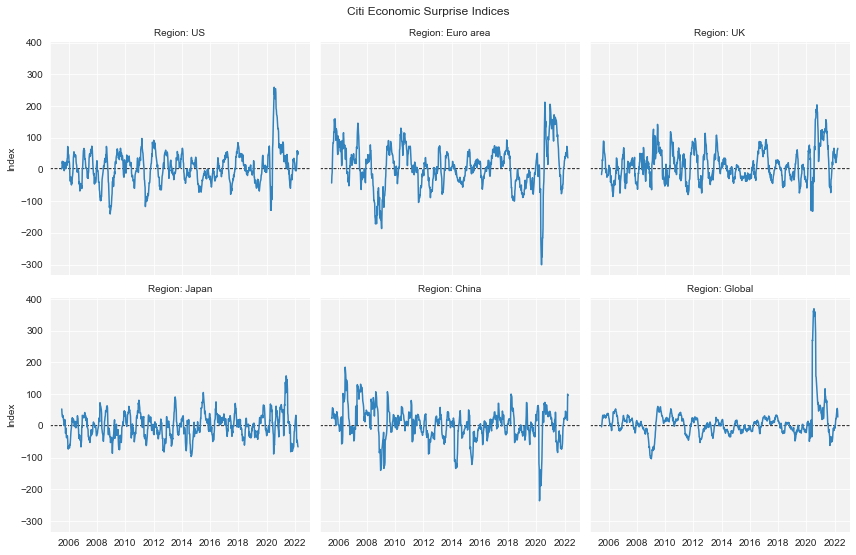

In [29]:
# Pre-processing for our charts
cesi_trends = empty_list['econ_sur'].melt(id_vars='date', var_name='type')
cesi_trends['type'] = cesi_trends['type'].map({'cesiusd':'US', 'cesieur':'Euro area', 'cesijpy':'Japan', 'cesigbp':'UK', 'cesicny':'China', 'cesiglf':'Global'})

# Charting
g= sns.relplot(data=cesi_trends, x='date', y='value', col='type', kind='line', col_wrap=3, aspect=1, height=4)
(g.map(plt.axhline, y=0, color="black", dashes=(2, 1), zorder=0).set_axis_labels("Date", "Index").set_titles("Region: {col_name}").tight_layout(w_pad=1))
g.fig.subplots_adjust(top=.92)
g.fig.suptitle('Citi Economic Surprise Indices')
g.set_xlabels("")

**Price-earnings / Price-book ratios**

The **price-to-earnings ratio (P/E)** is the ratio for valuing a company that measures its current share price relative to its earnings per share (EPS). There are two types of EPS metrics: (1) the forward P/E, and the (2) trailing P/E. Our focus is on the forward (or leading) P/E, which uses future earnings guidance rather than trailing figures. This is useful for comparing current earnings to future earnings and helps provide a clearer picture of what earnings will look like - without changes and other accounting adjustments.

Similarly, the **price-to-book ratio (P/B)** is calculated by dividing the company's stock price by its book value per share (BVPS). An asset's book value is equal to its carrying value on the balance sheet. The P/B ratio reflects the value that market participants attach to a company's equity relative to the book value of its equity. The book value of equity is an accounting measure based on the historic cost principle and reflects past issuances of equity, augmented by any profits or losses, and reduced by dividends and share buybacks.



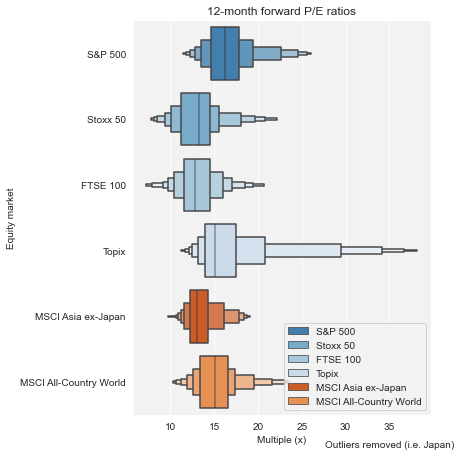

In [30]:
# Pre-processing for our charts
pe_trends = empty_list['pe'].melt(id_vars='date', var_name='type')

pe_trends['type'] = pe_trends['type'].map({'spx_pe':'S&P 500', 'sx5e_pe':'Stoxx 50', 'ftse100_pe':'FTSE 100', 'tpx_pe':'Topix', 'msci_axj_pe':'MSCI Asia ex-Japan', 'msci_acw_pe':'MSCI All-Country World'})

# Charting
sns.catplot(data=pe_trends, y='type', x='value', kind='boxen', hue='type', aspect=1, height=6, showfliers=False, legend=False, dodge=False)
plt.title("12-month forward P/E ratios")
plt.text(35, 6, "Outliers removed (i.e. Japan)", ha='center')
plt.xlabel("Multiple (x)")
plt.ylabel("Equity market")
plt.legend(loc="lower right")

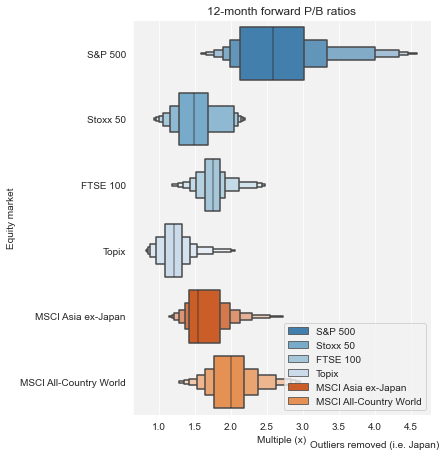

In [31]:
# Pre-processing for our charts
pb_trends = empty_list['pb'].melt(id_vars='date', var_name='type')

pb_trends['type'] = pb_trends['type'].map({'spx_pb':'S&P 500', 'sx5e_pb':'Stoxx 50', 'ftse100_pb':'FTSE 100', 'tpx_pb':'Topix', 'msci_axj_pb':'MSCI Asia ex-Japan', 'msci_acw_pb':'MSCI All-Country World'})

# Charting
sns.catplot(data=pb_trends, y='type', x='value', kind='boxen', hue='type', aspect=1, height=6, showfliers=False, legend=False, dodge=False)
plt.title("12-month forward P/B ratios")
plt.text(4, 6, "Outliers removed (i.e. Japan)", ha='center')
plt.xlabel("Multiple (x)")
plt.ylabel("Equity market")
plt.legend(loc="lower right")

### Volatility indices
The **VIX** index is a calculation designed to produce a measure of constant, 30-day expected volatility of the U.S. stock market, derived from real-time, mid-quote prices of S&P 500 Index call and put options. On a global basis, it is one of the most recognized measures of volatility - widely reported by financial media and closely followed by a variety of market participants as a daily market indicator.

The components of the VIX Index are near- and next-term put and call options with more than 23 days and less than 37 days to expiration. These include SPX options with “standard” 3rd Friday expiration dates and “weekly” SPX options that expire every Friday, except the 3rd Friday of each month. Once each week, the SPX options used to calculate the VIX Index “roll” to new contract maturities.

The **MOVE** index can be a useful tool to measure bond market sentiment and is a useful complement to the VIX index. It is a well-recognized measure of U.S. interest rate volatility that tracks the movement in U.S. Treasury yield volatility implied by current prices of *one-month* over-the-counter options on 2-year, 5-year, 10-year and 30-year Treasuries.

Deutsche Bank's currency volatility index (**CVIX**) provides a daily measure of volatility in G7 currencies. The index provides a benchmark for currency market participants. The index is designed to represent investors’ expectation of future volatility, and is calculated as the arithmetic average of the *3-month* level of implied volatility for all the major currency pairs (Based on 4pm London BBA fix). 

**Weights**: EURUSD (35.90%), USDJPY (21.79%), GBPUSD (17.95%), USDCHF (5.13%), USDCAD (5.13%), AUDUSD (6.41%), EURJPY (3.85%), EURGBP (2.56%), EURCHF (1.28%); Trade-weights correspond to the average daily turnover in each cross.

The CBOE **SKEW** index is a measure of the perceived tail risk in the S&P 500 based on deep out-of-the-money options - estimates the skewness of S&P 500 returns at the end of a *30-day* horizon. Consider the fact that most market participants are 'passive long', which means they are exposed to fluctuations in the market. Someone is more likely to express concerns following a 2% down day for the S&P 500 as opposed to a 2% up-day (This was usually a trigger to publish something!). So we can infer that there is a huge pool of natural buyers for S&P 500 downside protection (puts). Supply on the other hand, is still sizeable but narrower (i.e. selling OTM S&P 500 puts and purchase OTM calls). Simply put, there is a volatility skew, which describes the obervation that options with different strike prices, but the same underlying asset and expiration date can have different implied volatilities (Smiles vs. smirks).

When the S&P 500 falls, a few things typically occur in the index options marketplace. Typically, at-the-money (ATM) implied volatility levels increase, which usually sees the VIX move higher. To get a sense of what high or very high tail risk means, one can translate the value of SKEW to a risk-adjusted probability that the one-month S&P 500 log-return falls two or three standard deviations below the mean, and use VIX as an indicator of the magnitude of the standard deviation.

*Note*: S&P 500 skewness (S) is calculated from a portfolio of S&P 500 options that mimics an exposure to a skewness payoff. It tends to be negative and varies within a narrow range. It is transformed to SKEW by the following function: **SKEW = 100 - 10 x S**.

Text(0.5, 0.98, 'Volatility indices (Equities, Bonds, FX)')

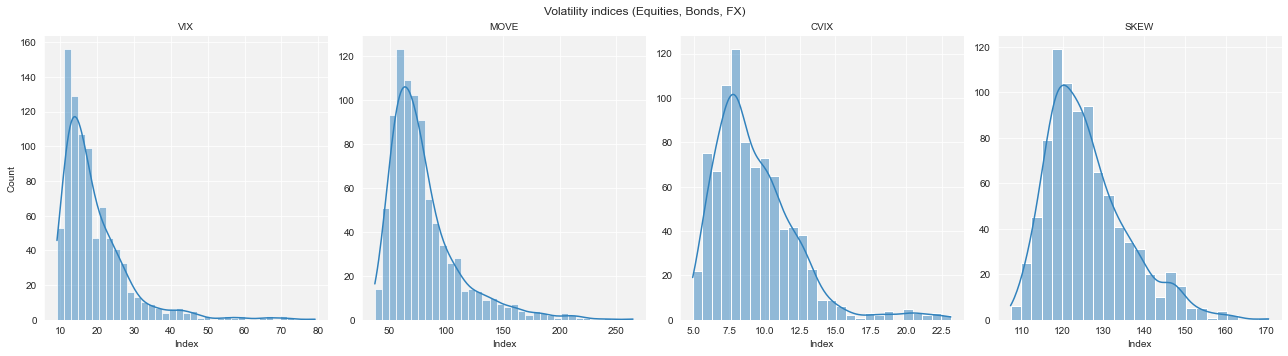

In [32]:
# Pre-processing for our charts
vol_trends = empty_list['vol'].melt(id_vars='date', var_name='type')

vol_trends['type'] = vol_trends['type'].map({'vix':'VIX', 'move':'MOVE', 'cvix':'CVIX', 'skew':'SKEW'})

# Charting
g = sns.FacetGrid(data=vol_trends, col='type', sharex=False, sharey=False, height=5, aspect=0.9)
g.map_dataframe(sns.histplot, x='value', kde=True).set_axis_labels("Index", "Count").set_titles("{col_name}").tight_layout(w_pad=1)
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Volatility indices (Equities, Bonds, FX)')

**Thoughts**: The distributions of these volatility indices are extremely right-skewed. We'll need to log-transform them.

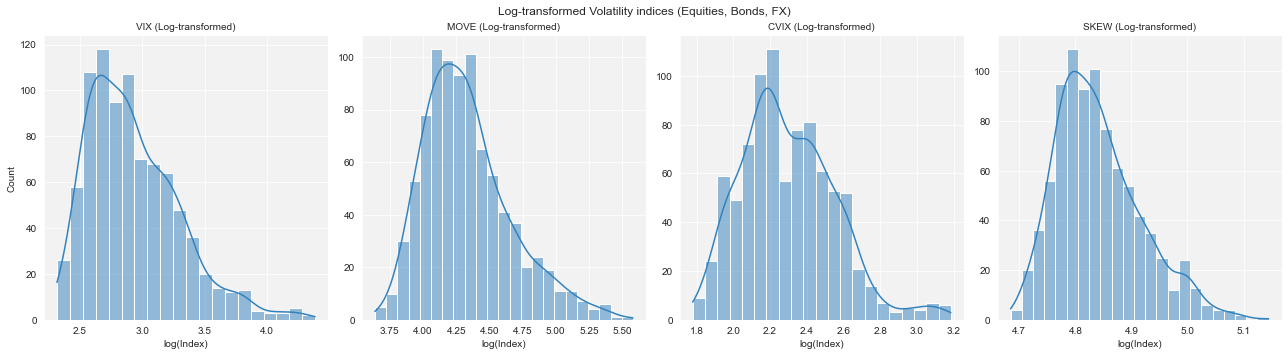

In [33]:
# Pre-processing for our charts
vol_trends_tidied = np.log1p(empty_list['vol'].set_index('date')).reset_index().melt(id_vars='date', var_name='type')

vol_trends_tidied['type'] = vol_trends_tidied['type'].map({'vix':'VIX', 'move':'MOVE', 'cvix':'CVIX', 'skew':'SKEW'})

# Charting
g = sns.FacetGrid(data=vol_trends_tidied, col='type', sharex=False, sharey=False, height=5, aspect=0.9)
g.map_dataframe(sns.histplot, x='value', kde=True).set_axis_labels("log(Index)", "Count").set_titles("{col_name} (Log-transformed)").tight_layout(w_pad=1)
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Log-transformed Volatility indices (Equities, Bonds, FX)')
plt.show()

### Earnings revision ratios
Defined as the rolling 3-month (13-week) ratio of analyst earnings upgrades over downgrades for FY1. A low and decreasing ERI should not bode well for S&P 500 returns in the near to medium-term.

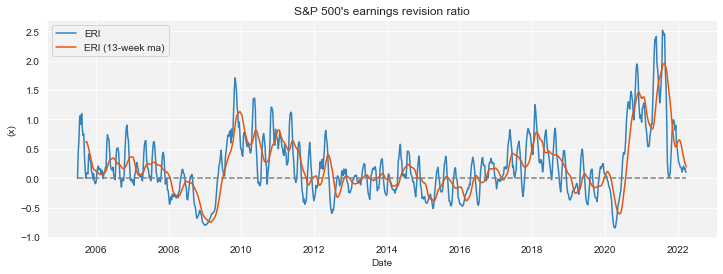

In [61]:
# Calculation of S&P 500's earnings revision ratio
eri['net'] = eri['upgrades']/eri['downgrades'] -1
eri['eri'] = eri['net'].rolling(13).mean()

# Visualising our series
plt.figure(figsize=(12,4))
sns.lineplot(data=eri, x='date', y=eri['net'], label="ERI")
sns.lineplot(data=eri, x='date', y=eri['eri'], label="ERI (13-week ma)", color=sns.color_palette('tab20c')[4])
sns.lineplot(data=eri, x='date', y=0, linestyle="--", color='grey')
plt.title("S&P 500's earnings revision ratio")
plt.xlabel("Date")
plt.ylabel("(x)")
plt.show()


### Positioning proxies
**CFTC explanatory notes**

Open interest is the total of all futures and/or option contracts entered into and not yet offset by a transaction, by delivery, by exercise, etc. The aggregate of all long open interest is equal to the aggregate of all short open interest. Open interest held or controlled by a trader is referred to as that trader's position.

When an individual reportable trader is identified to the Commission, the trader is classified either as **"commercial"** or **"non-commercial."** All of a trader's reported futures positions in a commodity are classified as commercial if the trader uses futures contracts in that particular commodity for hedging as defined in *CFTC Regulation 1.3, 17 CFR 1.3(z)*. A trading entity generally gets classified as a "commercial" trader by filing a statement with the Commission, on CFTC Form 40: Statement of Reporting Trader, that it is commercially "...engaged in business activities hedged by the use of the futures or option markets." 

To ensure that traders are classified with accuracy and consistency, Commission staff may exercise judgment in re-classifying a trader if it has additional information about the trader’s use of the markets. A trader may be classified as a commercial trader in some commodities and as a non-commercial trader in other commodities. A single trading entity cannot be classified as both a commercial and non-commercial trader in the same commodity. Nonetheless, a multi-functional organization that has more than one trading entity may have each trading entity classified separately in a commodity. For example, a financial organization trading in financial futures may have a banking entity whose positions are classified as commercial and have a separate money-management entity whose positions are classified as non-commercial.

We are choosing to monitor net non-commercial (speculative) positions as it is a useful indicator for analysing market sentiment.

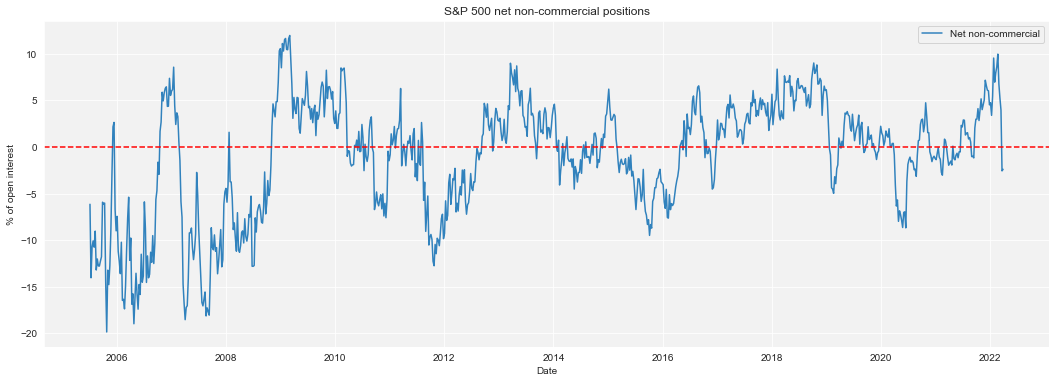

In [35]:
# S&P 500 positioning
us_cftc = empty_list['us_cftc']
us_cftc['cftc_nc_long_pct'] = us_cftc['cftc_nc_long'] / us_cftc['cftc_oi'] * 100
us_cftc['cftc_nc_short_pct'] = -us_cftc['cftc_nc_short'] / us_cftc['cftc_oi'] *100
us_cftc['cftc_nc_net_pct'] = us_cftc['cftc_nc_net'] / us_cftc['cftc_oi'] * 100

plt.figure(figsize=(18,6))
g = sns.lineplot(data=us_cftc, x='date', y='cftc_nc_net_pct', label="Net non-commercial")
g.axhline(y=0, color="red", linestyle="--")

plt.title("S&P 500 net non-commercial positions")
plt.xlabel("Date")
plt.ylabel("% of open interest")
plt.show()

**AAII Investor Sentiment Survey**

The survey has become a widely-followed measure of the mood of individual investors. The weekly survey results are published in financial publications including Barron's and Bloomberg, and are widely followed by market strategists, investment newsletters and other financial professionals.

The following question is posed to AAII members each week: "What direction do AAII members feel the stock market will be in the next 6 months?". The results are bullish, bearish and neutral. The first survey was conducted in 1987.

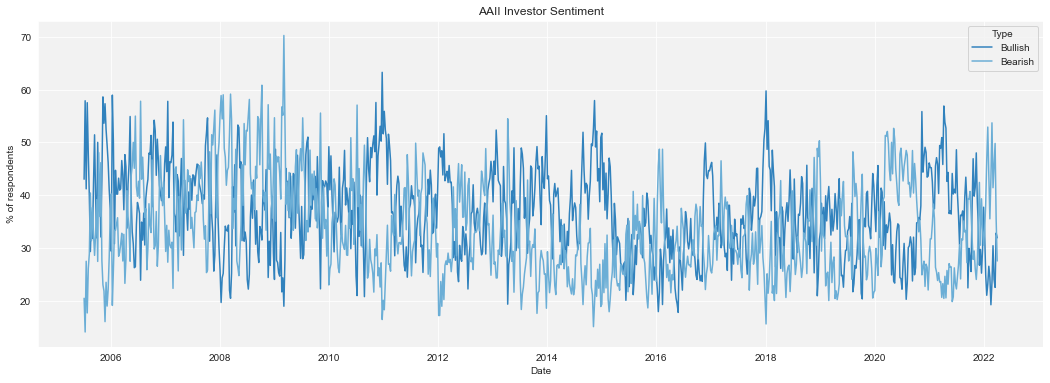

In [36]:
# AAII Investor Sentiment Survey
aaii = empty_list['aaii']
aaii_melt = aaii.melt(id_vars='date', value_name='Level', var_name='Type')
aaii_melt['Type'] = aaii_melt['Type'].map({'aaii_bull': 'Bullish', 'aaii_neut': 'Neutral', 'aaii_bear': 'Bearish'})

plt.figure(figsize=(18,6))
g = sns.lineplot(data=aaii_melt, x='date', y='Level', hue="Type")

plt.title("AAII Investor Sentiment")
plt.xlabel("Date")
plt.ylabel("% of respondents")
plt.show()

**Economic policy uncertainty indices**

These economic policy uncertainty (EPU) indices are based on newspaper coverage frequency. Several types of evidence—including human readings of 12,000 newspaper articles—indicate that this index proxies for movements in policy-related economic uncertainty. The US index I have picked spikes near tight presidential elections, Gulf Wars I and II, the 9/11 attacks, the failure of Lehman Brothers, the 2011 debt ceiling dispute, and other major battles over fiscal policy. 

Policy uncertainty is associated with greater stock price volatility and reduced investment and employment in policy-sensitive sectors like defense, health care, finance, and infrastructure construction. At the macro level, innovations in policy uncertainty foreshadow declines in investment, output, and employment. This should be a driver for the equity market.

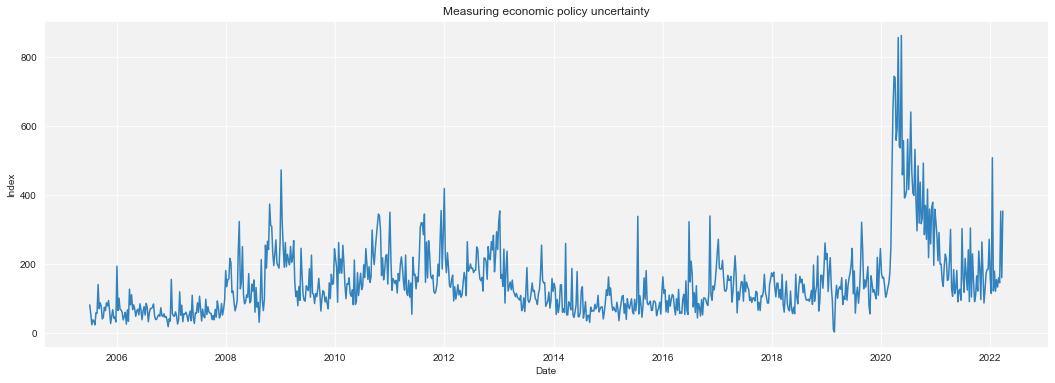

In [37]:
# Baker, Bloom and Davis' economic policy uncertainty index
epu = empty_list['epu']

plt.figure(figsize=(18,6))
g = sns.lineplot(data=epu, x='date', y='us_epu')

plt.title("Measuring economic policy uncertainty")
plt.xlabel("Date")
plt.ylabel("Index")
plt.show()

**Financial conditions**

The Chicago Fed’s National Financial Conditions Index (NFCI) provides a comprehensive weekly update on U.S. financial conditions in money markets, debt and equity markets and the traditional and “shadow” banking systems.

Like the Chicago Fed’s National Activity Index (CFNAI), the NFCI is a weighted average of a large number of variables (105 measures of financial activity) each expressed relative to their sample averages and scaled by their sample standard deviations.

Tighter financial conditions indicate tighter liquidity and could weigh on risk assets.

Text(0.5, 0.98, 'Financial Conditions')

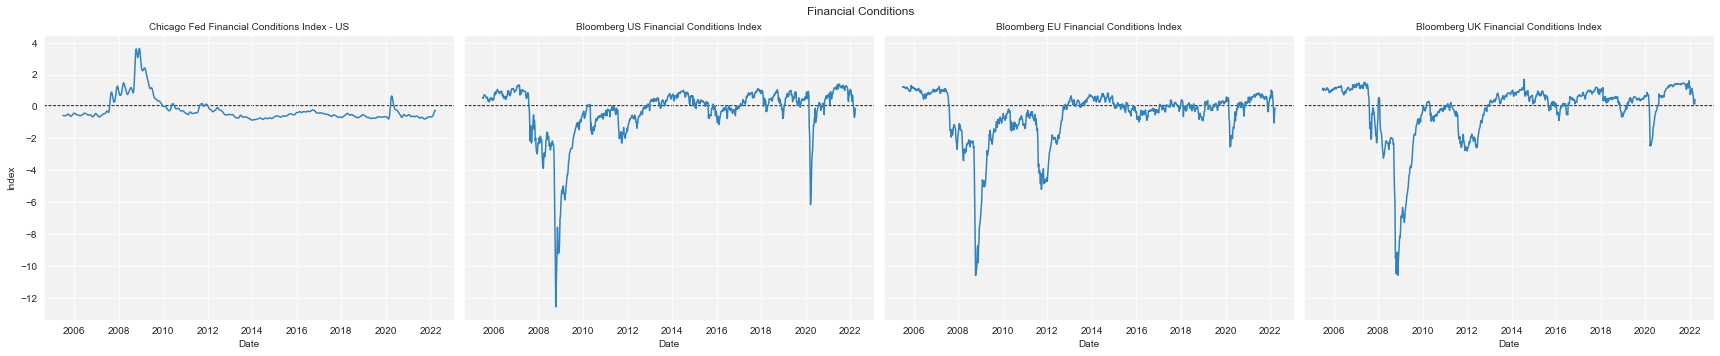

In [38]:
# Financial condition indices
finc = empty_list['finc'].melt(id_vars='date', var_name='type')
finc['type'] = finc['type'].map({'chicago_fed_finc':'Chicago Fed Financial Conditions Index - US', 'bbg_us':'Bloomberg US Financial Conditions Index', 'bbg_eu':'Bloomberg EU Financial Conditions Index', 'bbg_uk':'Bloomberg UK Financial Conditions Index'})

# Charting
g= sns.relplot(data=finc, x='date', y='value', col='type', kind='line', col_wrap=4, aspect=1.2, height=5)
(g.map(plt.axhline, y=0, color="black", dashes=(2, 1), zorder=0).set_axis_labels("Date", "Index").set_titles("{col_name}").tight_layout(w_pad=1))
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Financial Conditions')


**Interest rate expectations**

The Euro-dollar futures market is the deepest and mmost liquid derivatives market in the world. Eurodollar futures are essentially the market's best guess of what future 3-month LIBOR rates will be. Since 3-month rates are firmly within the Fed's control, this is largely a bet as to what the Fed wil do in the future, which in turn is a bet based on how economic conditions will unfold.

Note: We will only retain them if they do not exhibit a fairly high correlation to US Treasury yields

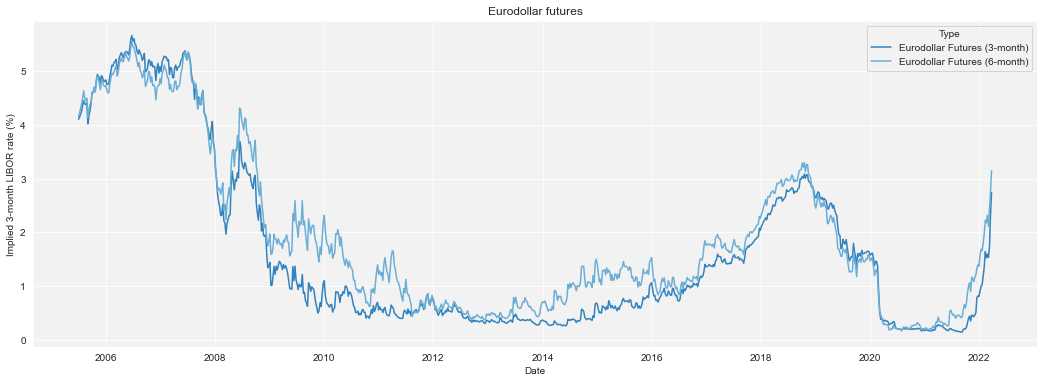

In [39]:
eurdollar = empty_list['eurdollar'].set_index('date').apply(lambda x: 100-x).drop(columns=['ed1', 'ed2']).reset_index()

# Charting
eurdollar_melt = eurdollar.melt(id_vars='date', value_name='Level', var_name='Type')
eurdollar_melt['Type'] = eurdollar_melt['Type'].map({'ed3': 'Eurodollar Futures (3-month)', 'ed6':'Eurodollar Futures (6-month)'})

plt.figure(figsize=(18,6))
g = sns.lineplot(data=eurdollar_melt, x='date', y='Level', hue="Type")

plt.title("Eurodollar futures")
plt.xlabel("Date")
plt.ylabel("Implied 3-month LIBOR rate (%)")
plt.show()

## Exploring our data
With the help of a really handy package (i.e. pandas_profiling), we can carry out our extensive EDA with just a few lines of code. We could always write a loop for this process, but I figured it'll be better to examine each dataset individually to check the shape of the overall distribution, interactions / multi-collinearity between different variables.

**Pros**: Warnings provided (NaN values, variables with many zeros, categorical variables with high cardinality, etc)

**Cons**: Use with larger datasets; Quadratic increase in time as the size of the dataset rises

In [40]:
# Exploring Citi Economic surprise indices
cesi_profile = ProfileReport(empty_list['econ_sur'], title="Citi Economic Surprise Indices", explorative=True)
cesi_profile.to_widgets()

Generate report structure: 100%|██████████| 1/1 [00:03<00:00,  3.92s/it]


**Thoughts**: US economic surprises are highly correlated with Euro area, UK, China and global indices. We could technically leave Japan in, but we posit it will likely not have a significant impact on final model. We will probably create additional features here. We've done the same analysis for other datasets.

**Action plan**: Keep `cesiusd` and drop the rest. We will also only retain P/E ratios for S&P 500.

In [41]:
# Exploring various commodity prices
como_profile = ProfileReport(empty_list['como'].set_index('date'), title="Commodities", explorative=True)
como_profile.to_widgets()

Generate report structure: 100%|██████████| 1/1 [00:08<00:00,  8.79s/it]


**Thoughts**: Most of the indices we've selected here do not appear to be significantly correlated with one another. 

**Action plan**: We can however, pick either Brent or WTI crude oil.

## Creation of custom functions
We will import our custom .py module (**SIREN_func**) which stores the following functions:
* `eda_clean`: Provides a quick snapshot of our project
* `derive_yield_curves`: Calculating 30y10ys, 30y5ys, 30y2ys, 30y3ms, 10y5ys, 10y2ys, 10y3ms, 5y2ys, 5y3ms, 2y3ms for US and Euro-area regions
* `fix_credit`: Standardising credit spreads as pp; Calculating spread between US high-yield and investment-grade bonds
* `fix_cftc`: Deriving CFTC net non-commercial positions as a % of total open interest
* `eri_diff`: Derive earnings revision indices and rolling changes across different horizons (4, 13-week)
* `roll_diff`: Calculate rolling differences for different time horizons (1, 4, 13, 26-week)
* `lag_roll_pct_chg`: Lagging rolling percentage changes for various equity indices (4-week)
* `roll_pct_chg`: Calculate rolling percentage changes for different time horizons (1, 4, 13, 26-week)
* `adjust_dates_only`: Standardise dates for merging dataframes later

We will once again rely on a combination of loops and custom functions to clean and tidy our dataset(s). We will also create some features for the following datasets:

* No engineering required (values-only; non-stationary)
* Rolling differences across different horizons (stationary)
    - Citi economic surprise indices (`econ_sur`)
    - US, Euro-area rates (`us_yields`, `eu_yields`)
        + Yield curves were also calculated
    - Credit spreads (`credit`)
* Rolling **percentage** changes across different horizons (stationary)
    - Equity indices (`eq_indices`)
    - USD indices (`usd`)
    - Commodities (`como`)
    - 12-month forward P/E ratios (`pe`)
    - 12-month forward P/B ratios (`pb`)

### Feature engineering

**Calculating differences across different horizons**

In [42]:
# Creating a empty dictionary to house our sub-dataset(s)
roll_d = {}

# Datasets of interest
for df in ['econ_sur', 'credit', 'us_yields', 'eu_yields', 'inflation', 'eurdollar']:
    if df in ['credit']:
        roll_d[f'{df}_chg'] = SIREN_func.roll_diff(SIREN_func.fix_credit(empty_list[df]))
    
    elif df in ['us_yields', 'eu_yields']:
        roll_d[f'{df}_chg'] = SIREN_func.roll_diff(SIREN_func.derive_yield_curves(empty_list[df]))

    elif df in ['eurdollar']:
        roll_d[f'{df}_chg'] = SIREN_func.roll_diff(SIREN_func.derive_eurodollar_pricing(empty_list[df]))

    else:
        roll_d[f'{df}_chg'] = SIREN_func.roll_diff(empty_list[df])

**Calculating percentage changes across different time horizons**

In [43]:
# Creating another empty dictionary to house sub-dataset(s)
roll_d2 = {}

# Datasets of interest
for df in ['usd', 'pe', 'pb', 'como', 'eq_indices']:
    if df in ['eq_indices']:
        roll_d2[f'{df}_4w_return'] = SIREN_func.lag_roll_pct_chg(empty_list[df], 4)
        
    else: 
        roll_d2[f'{df}_chg'] = SIREN_func.roll_pct_chg(empty_list[df]) # Tidy up with custom module later

**Storing the remaining time-series in a dictionary**

In [44]:
# Creating another empty dictionary to house sub-datasets
d3 = {}

# Datasets of interest
for df in ['epu', 'finc', 'pct52w', 'vol', 'aaii', 'us_cftc', 'technicals', 'fdtr']:
    if df in ['us_cftc']:
        d3[df] = SIREN_func.fix_cftc(empty_list[df])
    
    # elif df in ['vol']:
    #     d3[df] = SIREN_func.log_transform_adjust_dates(empty_list[df])

    else: d3[df] = SIREN_func.adjust_dates_only(empty_list[df])


In [45]:
# Merging out dictionaries
final_dict = {**roll_d, **roll_d2, **d3}

In [46]:
# Printing out our keys to our sub-dataset(s)
final_dict.keys()

dict_keys(['econ_sur_chg', 'credit_chg', 'us_yields_chg', 'eu_yields_chg', 'inflation_chg', 'eurdollar_chg', 'usd_chg', 'pe_chg', 'pb_chg', 'como_chg', 'eq_indices_4w_return', 'epu', 'finc', 'pct52w', 'vol', 'aaii', 'us_cftc', 'technicals', 'fdtr'])

**Tidying earnings revision ratios**

In [47]:
# Pipe custom function to calculate ERIs and 4, 13-week differences
eri_chg = SIREN_func.eri_diff(eri, 4, 13)

In [48]:
# Combining all our datasets
full = eri_chg.copy()
for df in final_dict.keys():
    full = pd.merge(left=full, right=final_dict[df], how='left', on='date')

In [49]:
# Columns to drop
prefixes = [
    'cesieur_', 'cesigbp_', 'cesicny_', 'cesijpy_','cesiglf_', 
    'sx5e_', 'ftse100_', 'msci_acw_', 'tpx_', 'msci_axj_', 'spx_pb',
    'vvix', 'eu_', 
    'usd_bbdxy', 'usd_dxy', 'cvix',
    'cftc_nc_long', 'cftc_oi', 'cftc_nc_short', 'cftc_nc_net', "us_baa",
    'aaii_bear', 'aaii_neut', 'em_usd_', 'global_hy_', 'asia_usd', 'us_hy_baa_spread',
    'bbg_us', 'bbg_uk', 'bbg_eu', 'wti', 'bcom_pm', 'bcom_en',
    'us_be10', 'us_5y5yswap', 'spx_pct_rsi14d_below30', 'spx_rsi9d', 'ed3_', 'ed6_'
    ]

unwanted = full.columns[full.columns.str.startswith(tuple(prefixes))]
unwanted

Index(['cesieur_1w_chg', 'cesigbp_1w_chg', 'cesijpy_1w_chg', 'cesicny_1w_chg',
       'cesiglf_1w_chg', 'cesieur_4w_chg', 'cesigbp_4w_chg', 'cesijpy_4w_chg',
       'cesicny_4w_chg', 'cesiglf_4w_chg',
       ...
       'cftc_nc_net', 'cftc_nc_long', 'cftc_nc_short', 'cftc_oi',
       'cftc_nc_long_pct', 'cftc_nc_short_pct', 'cftc_nc_net_pct',
       'cftc_nc_net_pct_oi', 'spx_rsi9d', 'spx_pct_rsi14d_below30'],
      dtype='object', length=153)

In [50]:
# Dropping unwanted columns
full_tidied = full.drop(columns=unwanted)

In [51]:
# Previewing our final dataset
SIREN_func.eda_clean(full_tidied)

Dataset Statistics:
Shape of dataframe: (874, 68)
% of Null values in dataframe: 1.02%
% duplicate rows: 0.0%

Column names: Index(['eri', 'eri_1m_chg', 'eri_3m_chg', 'cesiusd_1w_chg', 'cesiusd_4w_chg',
       'cesiusd_13w_chg', 'cesiusd_26w_chg', 'us_hy_1w_chg', 'us_hy_4w_chg',
       'us_hy_13w_chg', 'us_hy_26w_chg', 'us_2y_1w_chg', 'us_10y_1w_chg',
       'us_10y2ys_1w_chg', 'us_2y_4w_chg', 'us_10y_4w_chg', 'us_10y2ys_4w_chg',
       'us_2y_13w_chg', 'us_10y_13w_chg', 'us_10y2ys_13w_chg', 'us_2y_26w_chg',
       'us_10y_26w_chg', 'us_10y2ys_26w_chg', 'us_be5y5y_1w_chg',
       'us_10y_real_1w_chg', 'us_be5y5y_4w_chg', 'us_10y_real_4w_chg',
       'us_be5y5y_13w_chg', 'us_10y_real_13w_chg', 'us_be5y5y_26w_chg',
       'us_10y_real_26w_chg', 'usd_twi_1w_pctchg', 'usd_twi_4w_pctchg',
       'usd_twi_13w_pctchg', 'usd_twi_26w_pctchg', 'spx_pe_1w_pctchg',
       'spx_pe_4w_pctchg', 'spx_pe_13w_pctchg', 'spx_pe_26w_pctchg',
       'bcom_in_1w_pctchg', 'brent_1w_pctchg', 'gold_1w_pctchg',


In [52]:
# Let's save this down as a pickle file
full_tidied.to_pickle('../data/full.pkl')
empty_list['eq_indices'].to_pickle('../data/eq_indices.pkl')

---
